The data comes from Austin Animal Center from October 1st, 2013 to March, 2016. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake. 

In this competition, you are going to predict the outcome of the animal as they leave the Animal Center. These outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer. 

Data can be found at https://www.kaggle.com/c/shelter-animal-outcomes/data

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline


In [2]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from IPython.display import display
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

/home/muffinloop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


Path to the directory where you've downloaded the data

In [3]:
PATH = 'data/'

In [4]:
!ls {PATH}

sample_submission.csv  shelter-animal-outcomes.zip  test.csv  train.csv


Reading data in the form of a data frame, dropping some unneccesary columns

In [5]:
df = pd.read_csv(f'{PATH}train.csv', low_memory= False, parse_dates= ['DateTime'])
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [6]:
df.drop(['OutcomeSubtype'], axis = 1,  inplace = True)

In [7]:
"""
Function to display all rows and columns of a data frame.
Arguments : 
df : data frame you want to display
"""
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [8]:
display_all(df.tail())

,AnimalID,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26724,A702446,NaN,2015-05-14 11:56:00,Transfer,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
26725,A718934,NaN,2016-01-20 18:59:00,Transfer,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [9]:
df.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'AnimalType',
       'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

In [10]:
display_all(df.describe(include = 'all').T)

,count,unique,top,freq,first,last
AnimalID,26729,26729,A691031,1,NaT,NaT
Name,19038,6374,Max,136,NaT,NaT
DateTime,26729,22918,2015-08-11 00:00:00,19,2013-10-01 09:31:00,2016-02-21 19:17:00
OutcomeType,26729,5,Adoption,10769,NaT,NaT
AnimalType,26729,2,Dog,15595,NaT,NaT
SexuponOutcome,26728,5,Neutered Male,9779,NaT,NaT
AgeuponOutcome,26711,44,1 year,3969,NaT,NaT
Breed,26729,1380,Domestic Shorthair Mix,8810,NaT,NaT
Color,26729,366,Black/White,2824,NaT,NaT


Checking unique values of a few columns for better understanding

In [11]:
set(df.OutcomeType)

{'Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'}

In [12]:
set(df.AnimalType)

{'Cat', 'Dog'}

In [13]:
set(df.SexuponOutcome)

{'Intact Female',
 'Intact Male',
 'Neutered Male',
 'Spayed Female',
 'Unknown',
 nan}

In [14]:
len(df)

26729

Using the fastai add_datepart function to convert the DateTime column to a more usable form 

In [15]:
add_datepart(df, 'DateTime')

In [16]:
df.DateTimeDayofyear.head()

0     43
1    286
2     31
3    192
4    319
Name: DateTimeDayofyear, dtype: int64

The train_cats method converts all categorical column values to numbers. 

In [17]:
train_cats(df)

In [18]:
display_all(df.isnull().sum().sort_index()/len(df))

AgeuponOutcome              0.000673
AnimalID                    0.000000
AnimalType                  0.000000
Breed                       0.000000
Color                       0.000000
DateTimeDay                 0.000000
DateTimeDayofweek           0.000000
DateTimeDayofyear           0.000000
DateTimeElapsed             0.000000
DateTimeIs_month_end        0.000000
DateTimeIs_month_start      0.000000
DateTimeIs_quarter_end      0.000000
DateTimeIs_quarter_start    0.000000
DateTimeIs_year_end         0.000000
DateTimeIs_year_start       0.000000
DateTimeMonth               0.000000
DateTimeWeek                0.000000
DateTimeYear                0.000000
Name                        0.287740
OutcomeType                 0.000000
SexuponOutcome              0.000037
dtype: float64

The proc_df method, separates the response variable or the dependent variable (Here, OutcomeType) from the independent variables. Also it fills in NA values in every column with the median of that particular column.

In [19]:
X, y, nas = proc_df(df, 'OutcomeType')

Training the model, try 1

In [20]:
m = RandomForestClassifier(n_jobs = -1)
m.fit(X, y)
m.score(X, y)

1.0

Trained and tested the above model on the same data. It obviously is going to give really good results. Our goal is to train a model such that it gives good outputs for the data it has never seen before. 

Therefore, dividing the data into training and validation sets. 

In [21]:
def validation_split(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 4000
n_trn = len(X) - n_valid
raw_train, raw_valid = validation_split(df, n_trn)
X_train, X_valid = validation_split(X, n_trn)
y_train, y_valid = validation_split(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((22729, 20), (22729,), (4000, 20), (4000,))

In [22]:
def display_score(m):
    res = [
        m.score(X_train, y_train),
        m.score(X_valid, y_valid)
    ]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

Training the model, try 2

In [23]:
m = RandomForestClassifier(n_jobs = -1)
%time m.fit(X_train, y_train)
display_score(m)

CPU times: user 6.11 s, sys: 50.5 ms, total: 6.16 s
Wall time: 754 ms
[1.0, 0.6455]


The validation accuracy is 0.651, which isn't good.

Our model is over fitted. To help prevent over fitting, I have changed the n_estimators parameter value to 1, which by default is 100. The n_estimators parameter basically defines the number of trees in the forest

In [24]:
"""
the RandomForestClassifier from the sklearn library has various attributes,
n_estimators : lets us set the number of trees to grow while training.
max_depth : lets us set the maxiumum path (starting from root to a leaf node) for the trees
boostrap : Takes values True or False. Disables/enables randomization
n_jobs : lets us select the number of CPU cores to use while training. -1 means use all available cores.
"""
m = RandomForestClassifier(n_estimators = 1, max_depth = 3, bootstrap = False, n_jobs = -1)
m.fit(X_train, y_train)

display_score(m)

[0.5277838884244798, 0.5185]


The validation accuracy is worse than our previous model, which was using 10 n_estimators. To overcome this problem, I will be using a technique called Bagging. It's an ensemble technique, which basically states "averaging a bunch of crappy models is going to give us a really good model". Basically I will be creating multiple trees, averaging their errors and using the averaged model. One thing to take care of, all these individual models/trees should be as uncorrelated as possible. What I mean is, there shouldn't be and relationship between these individual trees. Otherwise, the bias of our model is going to be very high, which will lead to underfitting. 

In [25]:
m = RandomForestClassifier(n_jobs = -1, n_estimators = 10)
m.fit(X_train, y_train)
display_score(m)

[0.985877073342426, 0.63525]


Here, by default, the n_estimators variable takes the value of 100, but we will be using 10 trees only. I'll grab predictions from each of these individual trees and will be looking at one of these.

In [26]:
predictions = np.stack([t.predict(X_valid) for t in m.estimators_])
"""
estimators_ : is an attribute of the RandomForestClassifer, which contains information about each estimator/tree
"""
predictions[:,0], np.mean(predictions[:,0]), y_valid[0]

(array([1., 4., 4., 4., 4., 4., 0., 2., 4., 4.]), 3.1, 4)

In [27]:
predictions.shape

(10, 4000)

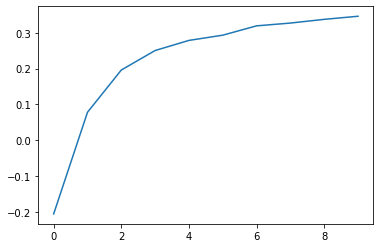

In [28]:
plt.plot([metrics.r2_score(y_valid, np.mean(predictions[:i+1], axis=0)) for i in range(10)]);

This curve really means that the parameter, n_estimators is almost tuned. Increasing ot decreasing the number of trees isnt going to help much.

In [29]:
# Trying to use n_estimators = 20 and 40

m = RandomForestClassifier(n_estimators = 20, n_jobs = -1)
m.fit(X_train, y_train)
display_score(m)

[0.9974481939372608, 0.64]


In [30]:
m = RandomForestClassifier(n_estimators = 40, n_jobs = -1)
m.fit(X_train, y_train)
display_score(m)

[0.9996920234062211, 0.651]


In [31]:
m = RandomForestClassifier(n_jobs = -1, n_estimators = 10, oob_score = True)
m.fit(X_train, y_train)
display_score(m)

/home/muffinloop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/muffinloop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[0.985525100092393, 0.63375, 0.5856394913986537]


This model is still overfitted. Lets reduce it.

In [32]:
# Using subsampling

x_trn, y_trn, nas = proc_df(df, 'OutcomeType')
X_train, X_valid = validation_split(x_trn, n_trn)
y_train, y_valid = validation_split(y_trn, n_trn)

In [33]:
X_train.shape, y_train.shape

((22729, 20), (22729,))

We want our model to see all the data, also ensuring that there is minimal correlation between individual models. We can achieve this by Subsampling, that is for this dataset, I took all 26729 rows, divided them into training and validation sets. While training, I'll be feeding each tree a different subset of my training data. This reduces the probability of two individual models seeing the same subset of data

In [34]:
set_rf_samples(1500)

In [35]:
m = RandomForestClassifier(n_jobs = -1, n_estimators = 10, oob_score= True)
m.fit(X_train, y_train)
display_score(m)

/home/muffinloop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/muffinloop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[0.9835452505609573, 0.625, 0.5867394078050068]


Since using the subsampling approach ensures that our model sees all the data. I am going to try use a higher value for the parameter n_estimators

In [36]:
m = RandomForestClassifier(n_jobs = -1, n_estimators = 20, oob_score = True)
m.fit(X_train, y_train)
display_score(m)

/home/muffinloop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/muffinloop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[0.9973602006247525, 0.646, 0.622816665933389]


In [37]:
m = RandomForestClassifier(n_jobs = -1, n_estimators = 40, oob_score = True)
m.fit(X_train, y_train)
display_score(m)

[0.9996040300937129, 0.64725, 0.6383474855910951]


In [38]:
def best_params(train_x, train_y):
    rfc = RandomForestClassifier()
    param_grid = { 
        'n_estimators': [50, 400],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(train_x, train_y)
    return CV_rfc.best_params_

print(best_params(X_train, y_train))

{'max_features': 'log2', 'n_estimators': 400}


Since I have tried many approaches to train my model and to prevent over fitting, I am going to test my model's predictions on a completely new dataset provided by kaggle itself. 

In [39]:
test_ = pd.read_csv(f'{PATH}test.csv', low_memory = False, parse_dates = ['DateTime'])
test_.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [40]:
add_datepart(test_, 'DateTime')

In [41]:
test_.DateTimeDayofyear.head()

0    285
1    207
2     13
3    362
4    267
Name: DateTimeDayofyear, dtype: int64

In [42]:
train_cats(test_)

In [43]:
display_all(test_.isnull().sum().sort_index()/len(test_))

AgeuponOutcome              0.000524
AnimalType                  0.000000
Breed                       0.000000
Color                       0.000000
DateTimeDay                 0.000000
DateTimeDayofweek           0.000000
DateTimeDayofyear           0.000000
DateTimeElapsed             0.000000
DateTimeIs_month_end        0.000000
DateTimeIs_month_start      0.000000
DateTimeIs_quarter_end      0.000000
DateTimeIs_quarter_start    0.000000
DateTimeIs_year_end         0.000000
DateTimeIs_year_start       0.000000
DateTimeMonth               0.000000
DateTimeWeek                0.000000
DateTimeYear                0.000000
ID                          0.000000
Name                        0.281512
SexuponOutcome              0.000000
dtype: float64

In [44]:
test_.head()

,ID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,DateTimeYear,DateTimeMonth,DateTimeWeek,DateTimeDay,DateTimeDayofweek,DateTimeDayofyear,DateTimeIs_month_end,DateTimeIs_month_start,DateTimeIs_quarter_end,DateTimeIs_quarter_start,DateTimeIs_year_end,DateTimeIs_year_start,DateTimeElapsed
0,1,Summer,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,2015,10,42,12,0,285,False,False,False,False,False,False,1444652100
1,2,Cheyenne,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,2014,7,30,26,5,207,False,False,False,False,False,False,1406397540
2,3,Gus,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,2016,1,2,13,2,13,False,False,False,False,False,False,1452687600
3,4,Pongo,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,2013,12,52,28,5,362,False,False,False,False,False,False,1388254320
4,5,Skooter,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,2015,9,39,24,3,267,False,False,False,False,False,False,1443117540


In [45]:
X_test, _, nas = proc_df(test_)

In [46]:
m = RandomForestClassifier(n_estimators=400, max_features='log2').fit(X_train, y_train)
print('Cross Validation for RandomForestClassifier')
print(m.score(X_valid, y_valid))

prediction = pd.DataFrame(m.predict_proba(X_test))
prediction.columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
prediction = pd.concat([X_test['ID'], prediction], axis=1)
prediction.to_csv('randomforest.csv', index=False)

prediction.head()

Cross Validation for RandomForestClassifier
0.652


,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.0550,0.0000,0.2725,0.3425,0.3300
1,2,0.3500,0.0000,0.0575,0.4875,0.1050
2,3,0.3975,0.0050,0.0650,0.3150,0.2175
3,4,0.1250,0.0000,0.2800,0.2800,0.3150
4,5,0.2050,0.0025,0.1525,0.5100,0.1300
